In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

In [16]:
IMG_SIZE = (192, 192)
BATCH_SIZE = 16

# Create ImageDataGenerators for training, validation, and test datasets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Increase rotation range
    width_shift_range=0.2,  # Increase shift range
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,  # Increase zoom range
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Add brightness augmentation
    fill_mode='nearest'
)


val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load the datasets
train_generator = train_datagen.flow_from_directory(
    'Training',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    'Validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    'Testing',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


Training Dataset:


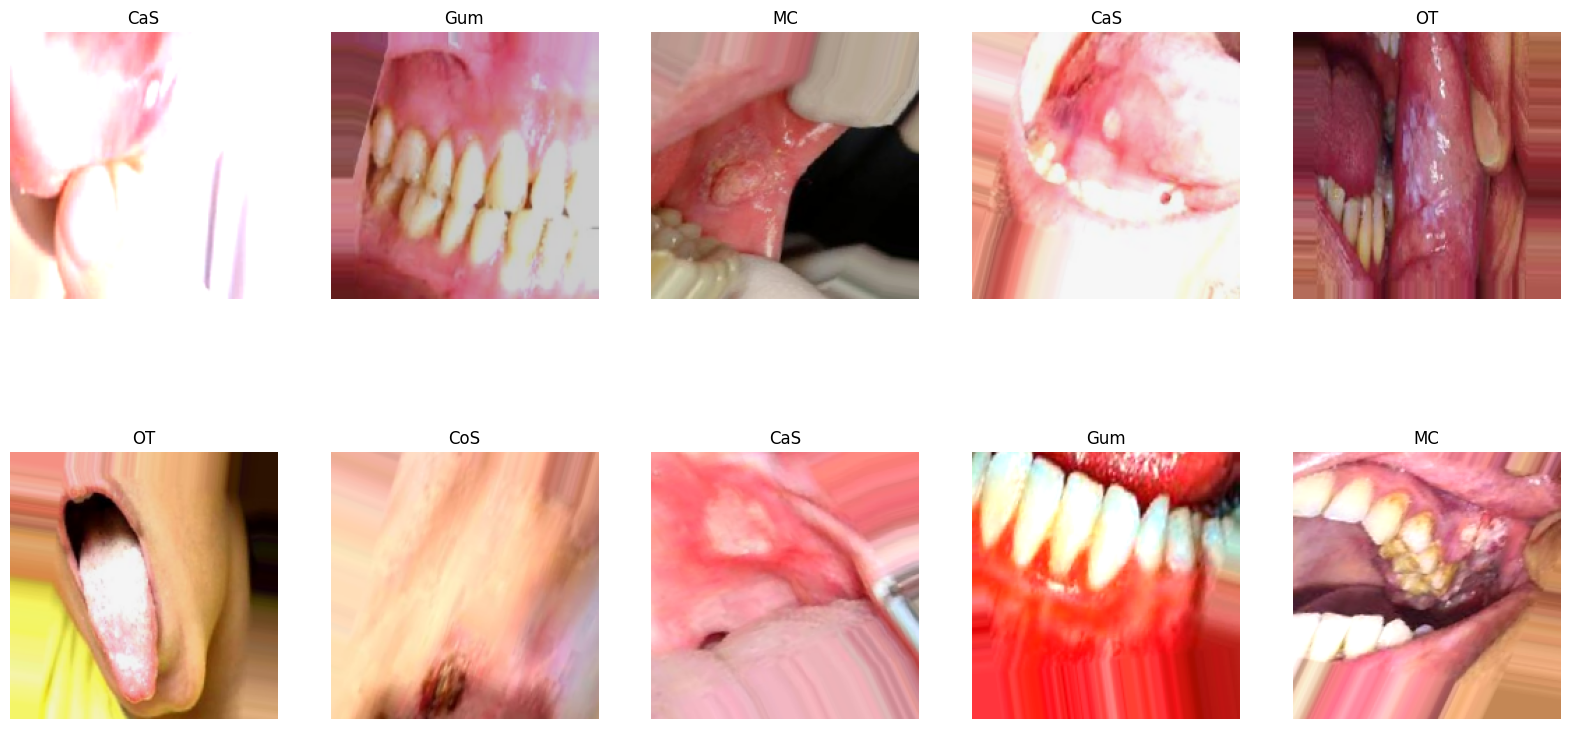


Validation Dataset:


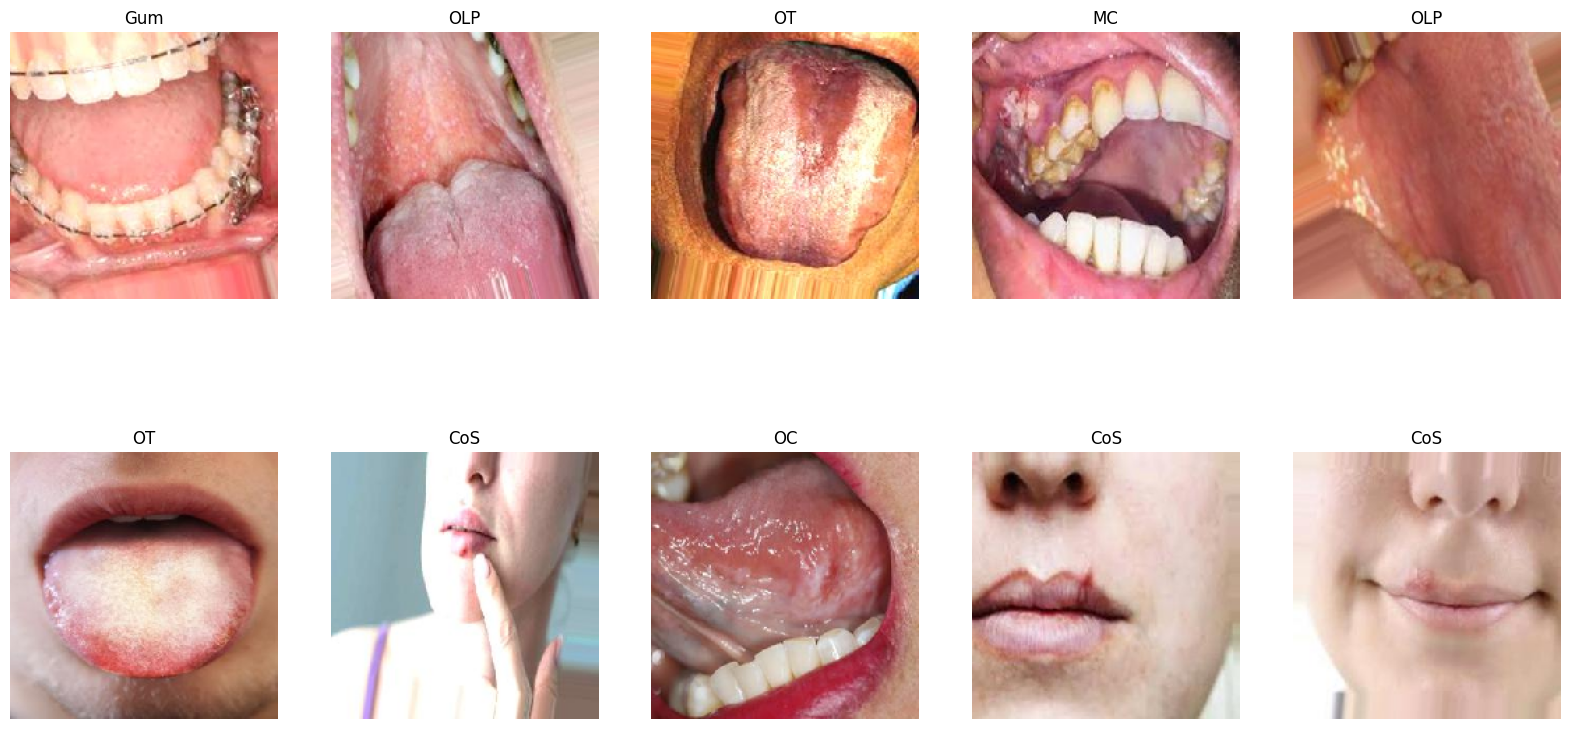


Testing Dataset:


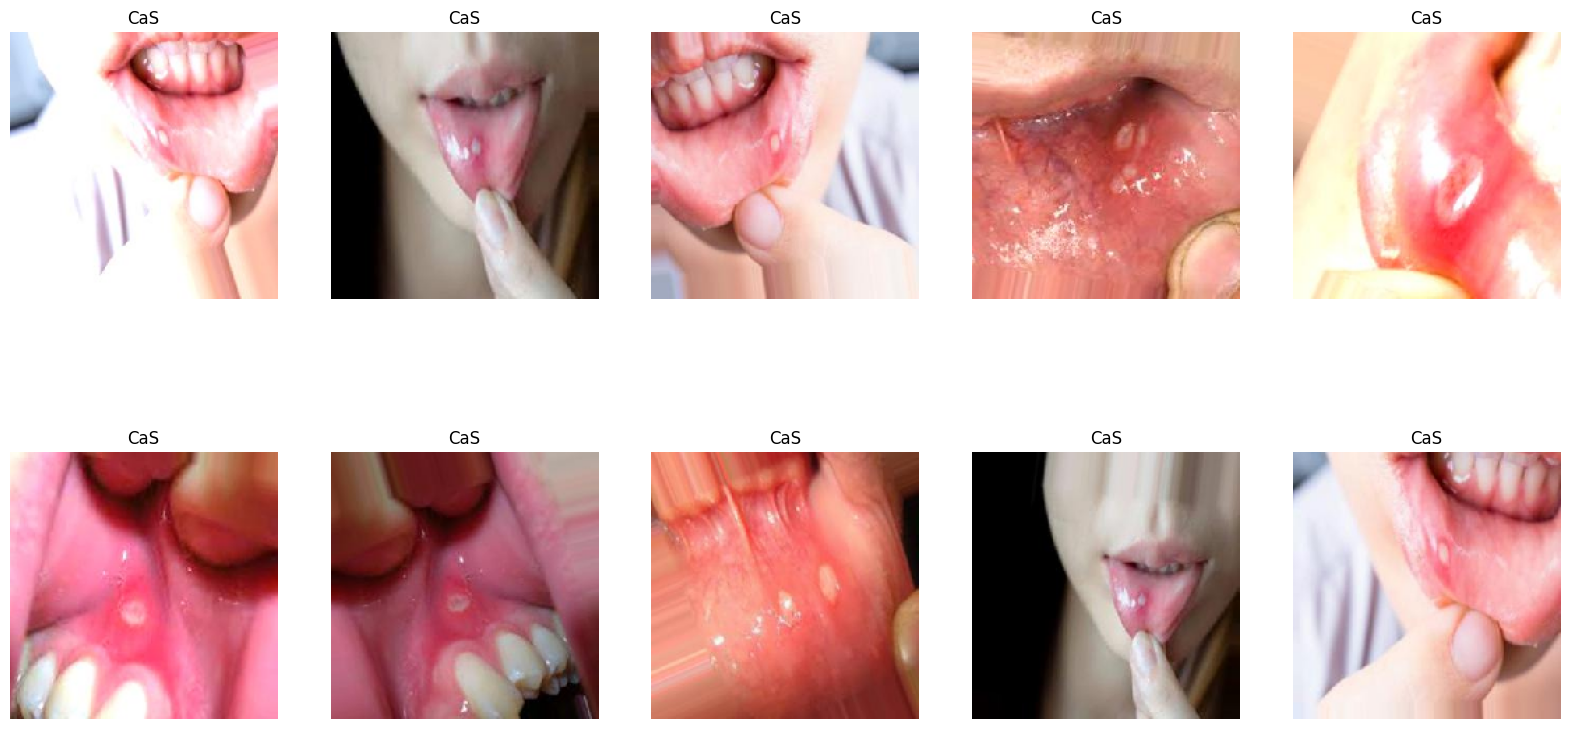

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(generator, n_samples=10):
    """Visualizes a random sample of images from a data generator."""
    images, labels = next(generator)  # Get a batch of images and labels
    indices = np.random.choice(range(len(images)), n_samples, replace=False)

    class_labels = list(generator.class_indices.keys())

    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices):
        ax = plt.subplot(2, n_samples // 2, i + 1)
        plt.imshow(images[idx])
        label = class_labels[np.argmax(labels[idx])]
        plt.title(label)
        plt.axis("off")

    plt.show()

# Visualize 10 samples from the training, validation, and testing datasets
print("Training Dataset:")
visualize_samples(train_generator, n_samples=10)
print("\nValidation Dataset:")
visualize_samples(val_generator, n_samples=10)
print("\nTesting Dataset:")
visualize_samples(test_generator, n_samples=10)


Training Data Augmentation:


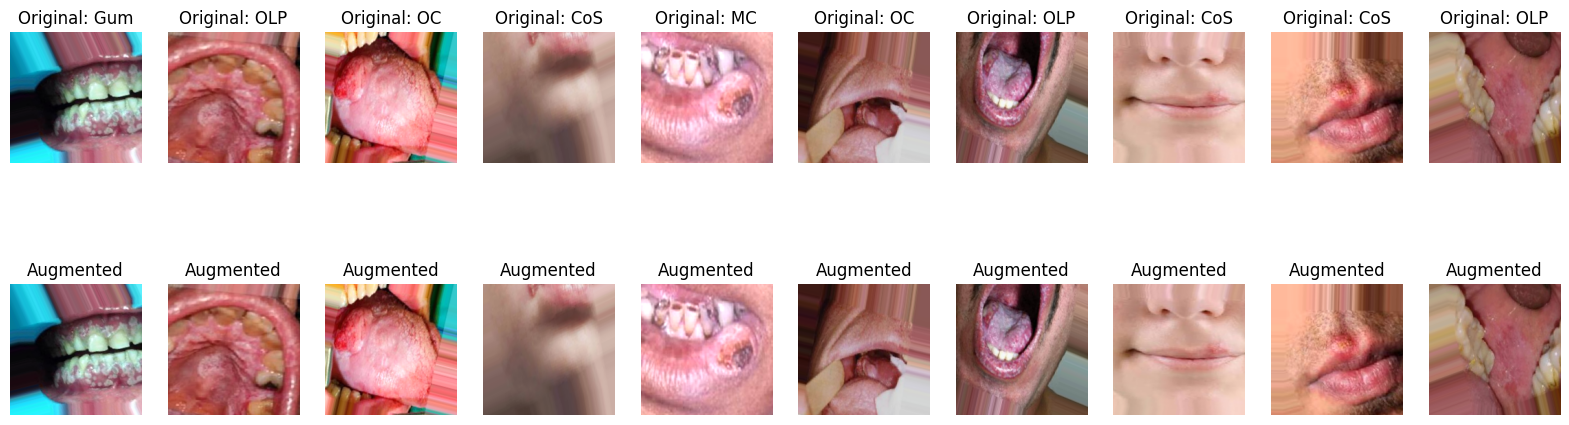

Validation Data Augmentation:


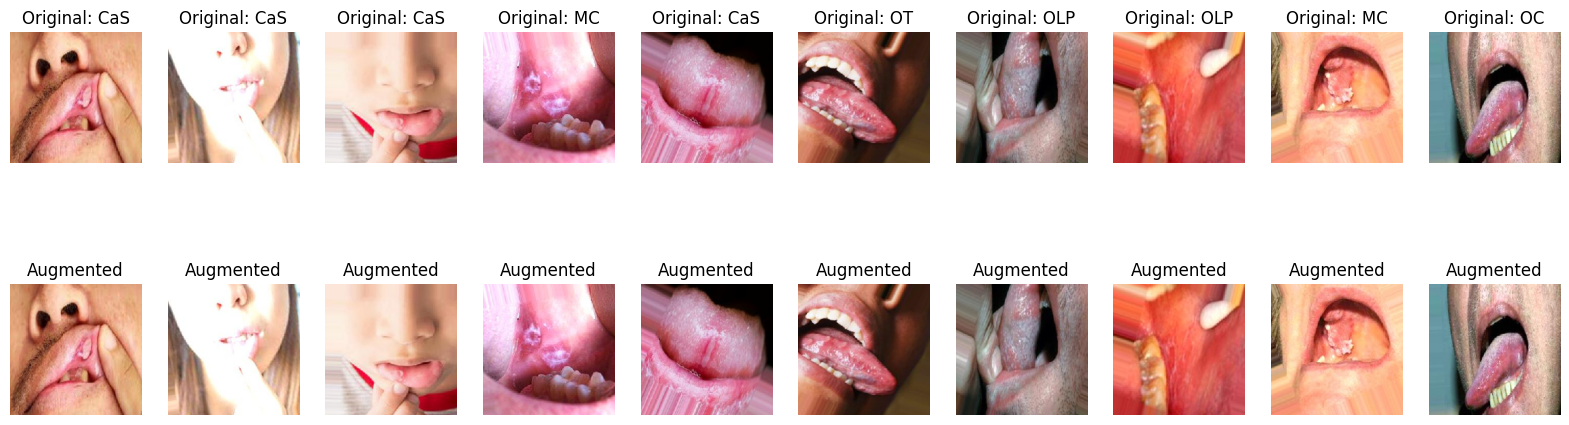

Testing Data Augmentation:


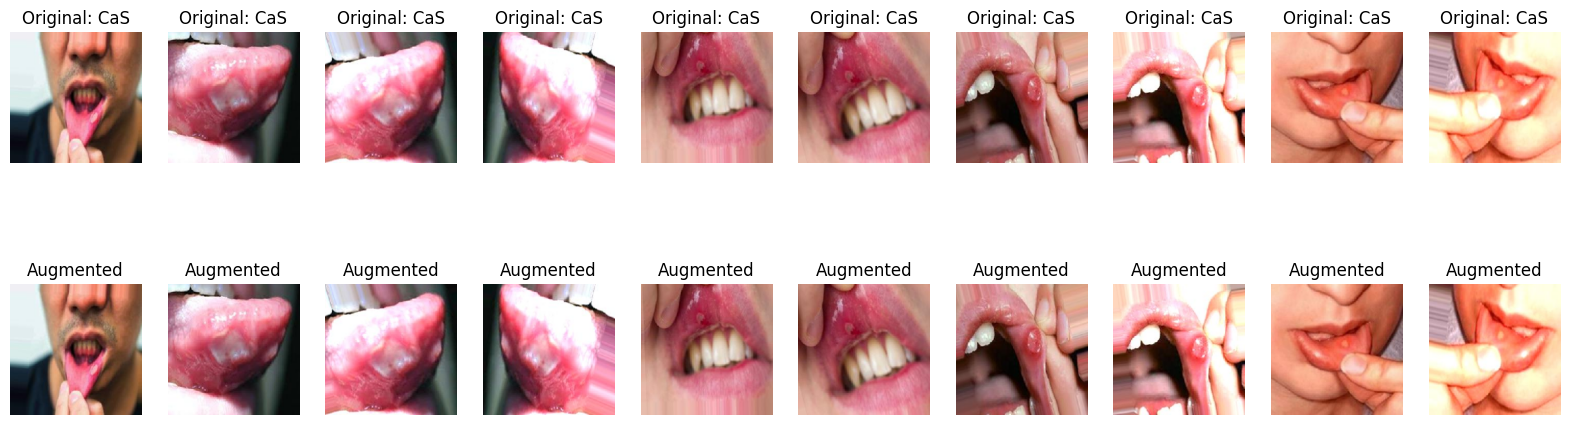

In [18]:
import numpy as np

def show_augmented_images(generator, n_images=10):
    images, labels = next(generator)

    fig, axes = plt.subplots(2, n_images, figsize=(20, 6))
    for i in range(n_images):
        # Original image
        axes[0, i].imshow(images[i])
        axes[0, i].set_title(f'Original: {list(generator.class_indices.keys())[np.argmax(labels[i])]}')
        axes[0, i].axis('off')

        # Augmented image (same as original here since we're showing the augmented data)
        axes[1, i].imshow(images[i])
        axes[1, i].set_title('Augmented')
        axes[1, i].axis('off')

    plt.show()

# Show augmented images for training, validation, and testing datasets
print("Training Data Augmentation:")
show_augmented_images(train_generator)

print("Validation Data Augmentation:")
show_augmented_images(val_generator)

print("Testing Data Augmentation:")
show_augmented_images(test_generator)


In [29]:
from tensorflow.keras.optimizers import Adam
model = Sequential([
    tf.keras.Input((192, 192, 3)),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),

    # Output Layer
    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 190, 190, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 95, 95, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 93, 93, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 46, 46, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 44, 44, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 20, 20, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 656,727 (2.51 MB)

 Trainable params: 656,727 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [early_stopping]

In [32]:
# Training the model
history = model.fit(
    train_generator,                # Training data generator
    validation_data=val_generator,  # Validation data generator
    epochs=100,                      # Number of epochs to train
    callbacks=callbacks,            # Any callbacks you want to use (like EarlyStopping, ModelCheckpoint, etc.
)

Epoch 1/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 34s 156ms/step - accuracy: 0.1907 - loss: 1.9356 - val_accuracy: 0.2276 - val_loss: 1.8650
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - accuracy: 0.2561 - loss: 1.8452 - val_accuracy: 0.3210 - val_loss: 1.6940
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.2753 - loss: 1.7724 - val_accuracy: 0.3648 - val_loss: 1.6355
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 27s 138ms/step - accuracy: 0.3292 - loss: 1.6811 - val_accuracy: 0.4066 - val_loss: 1.5275
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 27s 138ms/step - accuracy: 0.3578 - loss: 1.5969 - val_accuracy: 0.4319 - val_loss: 1.4507
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.3930 - loss: 1.5396 - val_accuracy: 0.3191 - val_loss: 1.7348
Epoch 7/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step - accuracy: 0.4112 - loss: 1.5132 - val_accuracy: 0.5311 - val_loss: 1.2633
Epoch 8/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 27s 138ms/step - accuracy: 0.4278 -

In [33]:
loss, accuracy = model.evaluate(test_generator)

# Print the results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9832 - loss: 0.0480
Test Loss: 0.0469
Test Accuracy: 0.9825


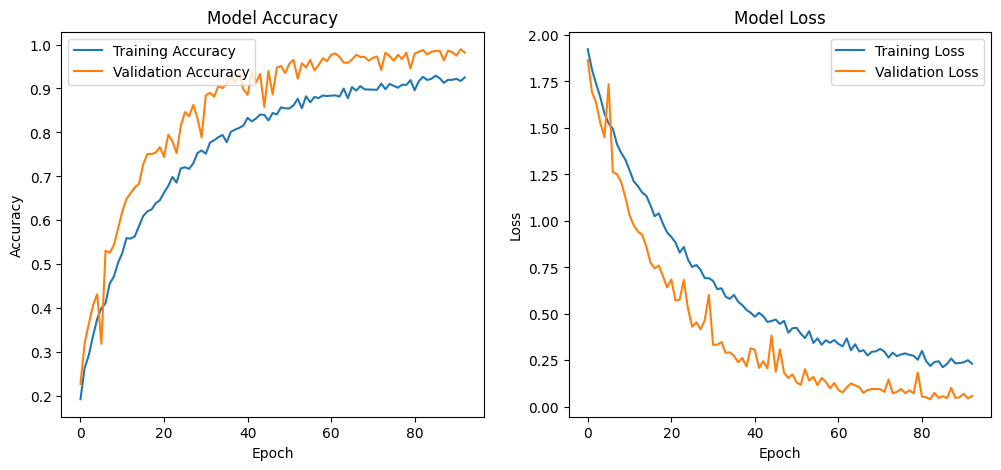

In [34]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Display the plots
plt.show()

In [35]:
import pickle

In [37]:
final_model = model # Assign the trained model to the variable final_model

# Save the model to a file named 'final_model.sav'
with open('final_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)